# PREPARAÇÃO

- OBJETIVOS
  - Preparar os dados para a etapa de modelagem preditiva
  - Selecionar as variaveis mais relevantes para prever o nivel de estresse dos estudantes

- ETAPAS
  - Carregar os datasets pre-processados (Original e Scaled)
  - Separar as variaveis independentes (X) e a variavel alvo (stress_level)
  - Aplicar métodos de seleção de features, utilizando diferentes abordagens:
    - Filtro: Mutual Information (medindo relevância individual das variaveis)
    - Wrapper: Recursive Feature Elimination (RFE) com Regressão Logistica
    - Embedded: Importancia das variaveis pelo Random Forest
  - Comparar os resultados dos metodos
  - Construir um ranking combinado de features
  - Criar diferentes subconjuntos (todas, top 10 e top 5) para teste
  - Salvar os subconjuntos para usar no proximo Colab


- PROXIMO COLAB
  - Treinar modelos baseline (Random Forest, Regressão Logística, SVM) em cada subconjunto de features
  - Comparar o desempenho dos modelos, verificando se a redução de atributos mantém ou melhora a acuracia



- Seleção de atributos (Mutual Info, RFE, RF): responde:
  - “Quais variáveis originais são mais importantes para prever o estresse?”

- PCA responde:
  - “É possível representar os dados em menos dimensões sem perder muita informação?”

- LDA responde:
  - “As classes de estresse são separáveis no espaço das features?”


## Carregamento

- Original e Scaled gerados no 0_PreProcessamento

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier


from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel


from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [ ]:
!pip install skfeature-chappers
from skfeature.function.similarity_based import fisher_score

In [ ]:
url_orig = "https://raw.githubusercontent.com/AnaClaraGuerra22/INF-493-CD/main/TRAB%20FINAL/DATASET/DATASET_PREPROCESSADOS/StressLevelDataset_Original.csv"
url_scaled = "https://raw.githubusercontent.com/AnaClaraGuerra22/INF-493-CD/main/TRAB%20FINAL/DATASET/DATASET_PREPROCESSADOS/StressLevelDataset_Scaled.csv"

In [ ]:
df_orig = pd.read_csv(url_orig)
print("Original:", df_orig.shape)
print(df_orig.head())

Original: (1100, 22)
   id_pessoa  anxiety_level  self_esteem  mental_health_history  depression  \
0          1             14           20                      0          11   
1          2             15            8                      1          15   
2          3             12           18                      1          14   
3          4             16           12                      1          15   
4          5             16           28                      0           7   

   headache  blood_pressure  sleep_quality  breathing_problem  noise_level  \
0         2               1              2                  4            2   
1         5               3              1                  4            3   
2         2               1              2                  2            2   
3         4               3              1                  3            4   
4         2               3              5                  1            3   

   ...  basic_needs  academic_perfo

In [ ]:
df_scaled = pd.read_csv(url_scaled)
print("Scaled:", df_scaled.shape)
print(df_scaled.head())




Scaled: (1100, 22)
   id_pessoa  anxiety_level  self_esteem  mental_health_history  depression  \
0          1       0.666667     0.666667                    0.0    0.407407   
1          2       0.714286     0.266667                    1.0    0.555556   
2          3       0.571429     0.600000                    1.0    0.518519   
3          4       0.761905     0.400000                    1.0    0.555556   
4          5       0.761905     0.933333                    0.0    0.259259   

   headache  blood_pressure  sleep_quality  breathing_problem  noise_level  \
0       0.4             0.0            0.4                0.8          0.4   
1       1.0             1.0            0.2                0.8          0.6   
2       0.4             0.0            0.4                0.4          0.4   
3       0.8             1.0            0.2                0.6          0.8   
4       0.4             1.0            1.0                0.2          0.6   

   ...  basic_needs  academic_perform

## Separar features (X) e target (y)



In [ ]:
X_orig = df_orig.drop(columns=["stress_level", "id_pessoa"])
X = df_scaled.drop(columns=["stress_level", "id_pessoa"])

y = df_orig["stress_level"]


## Dividir treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Seleçao de features

### TIPO FILTRO
PRIMEIRA TRIAGEM

**Mutual Information**

- O que fazem: avaliam cada variável de forma independente
- Vantagem: rápidos, fáceis de interpretar
- Limitação: não consideram interação entre variáveis

Mutual Information (relevância das variáveis):
blood_pressure                  0.744964
bullying                        0.669996
future_career_concerns          0.668781
sleep_quality                   0.666586
depression                      0.660121
anxiety_level                   0.659608
self_esteem                     0.624397
headache                        0.573681
academic_performance            0.518681
extracurricular_activities      0.517744
teacher_student_relationship    0.517739
social_support                  0.513235
safety                          0.510815
basic_needs                     0.506121
peer_pressure                   0.484187
noise_level                     0.446680
study_load                      0.391109
living_conditions               0.387597
breathing_problem               0.367571
mental_health_history           0.239563
dtype: float64


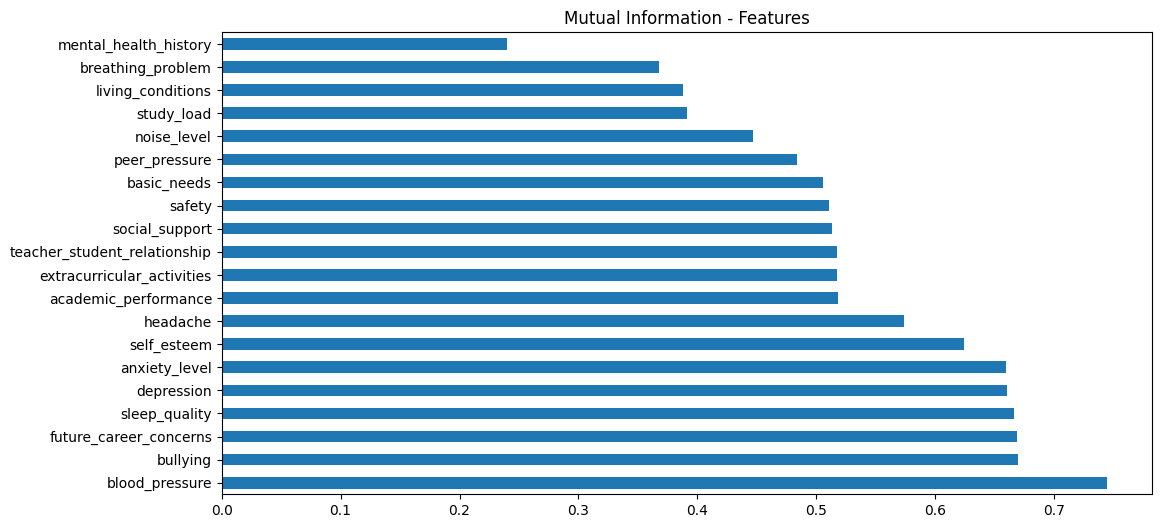

In [ ]:
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Mutual Information (relevância das variáveis):")
print(mi_series)


mi_series.plot(kind="barh", figsize=(12,6), title="Mutual Information - Features")
plt.show()


Conclusão do MI

- O ranking mostra que a predição do nível de estresse é influenciado por uma combinação de fatores fisiológicos, sociais e psicológicos

- Fatores Fisiológicos e Sociais Dominam o Topo:
O resultado mais surpreendente é a posição de *blood_pressure* e *bullying*

  - *blood_pressure* (0.745): Segundo MI, é a variável mais relevante para prever o nível de estresse. Isso sugere que o conjunto de dados pode ter sido rotulado ou que o estresse manifestado está fortemente correlacionado com uma resposta fisiológica primária e facilmente mensurável.

  - *bullying* (0.670): O segundo fator mais relevante é social. O ambiente social tóxico tem um impacto mais informativo no nível de estresse do que a maioria dos fatores internos

- Os fatores psicológicos ainda são extremamente relevantes, mas não estão isoladamente no topo:

  - *future_career_concerns* (0.669), *depression* (0.660), *anxiety_level* (0.660): Essas variáveis formam o núcleo do estresse mental.

  - *self_esteem* (0.624): Apesar de ser crucial, tem um MI score um pouco abaixo dos fatores mais críticos, sugerindo que não é o principal motor do estresse.

- Fatores com Baixa Relevância

  - *mental_health_history* (0.240): Este é o mais fraco. Isso pode indicar que o *stress_level*  reflete um estado atual e é pouco influenciado pelo histórico clínico

  - *study_load* (0.391) e *living_conditions* (0.388): Estes fatores ambientais e de carga de trabalho são preditores fracos. Isso reforça a ideia de que o impacto do estresse é mais interno (mental/físico) e social (bullying) do que a simples carga de estudos ou o local onde o aluno mora

### Tipo Wrapper

**Recursive Feature Elimination (RFE)**

- O que fazem: testam combinações de variáveis com um modelo preditivo (ex.: RFE, Forward Selection)

- Vantagem: capturam interações entre atributos

- Limitação: mais lentos (custam caro em datasets grandes)


In [ ]:
# regressao logistica
model = LogisticRegression(max_iter=200, random_state=42)
rfe = RFE(model, n_features_to_select=10)  # top 10
rfe.fit(X, y)

rfe_support = pd.Series(rfe.support_, index=X.columns)
rfe_ranking = pd.Series(rfe.ranking_, index=X.columns)

print("Features selecionadas pelo RFE:")
print(rfe_support[rfe_support].index.tolist())


Features selecionadas pelo RFE:
['self_esteem', 'headache', 'blood_pressure', 'sleep_quality', 'noise_level', 'safety', 'basic_needs', 'teacher_student_relationship', 'social_support', 'extracurricular_activities']


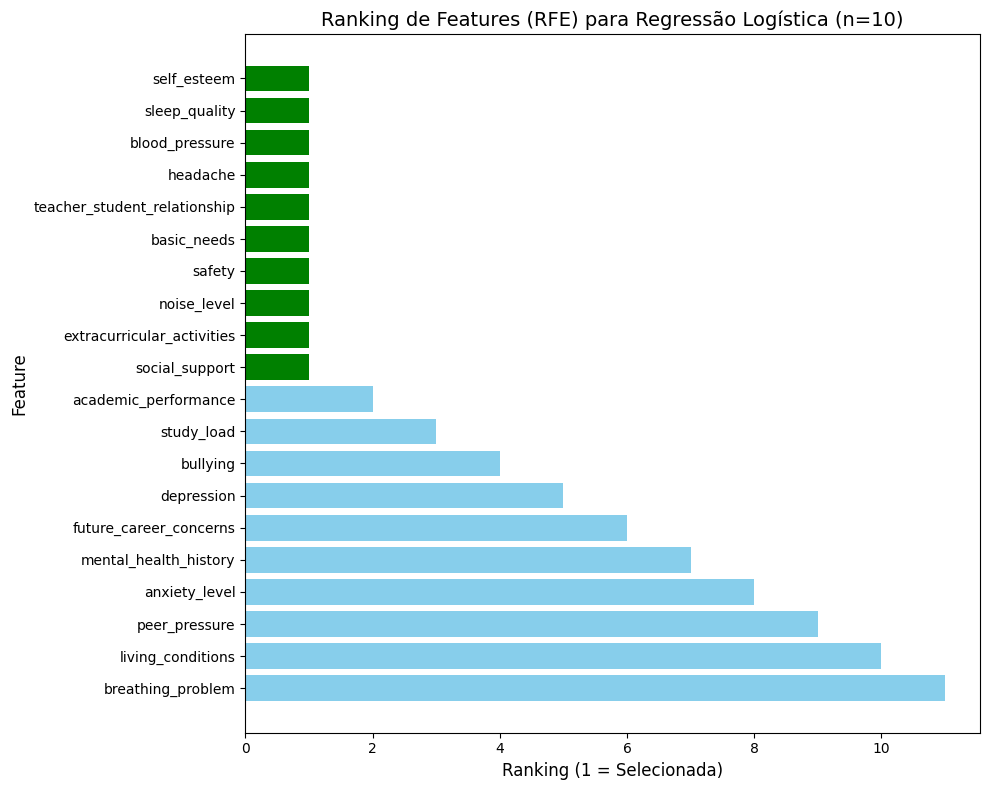


--- Features Selecionadas ---
['self_esteem', 'sleep_quality', 'blood_pressure', 'headache', 'teacher_student_relationship', 'basic_needs', 'safety', 'noise_level', 'extracurricular_activities', 'social_support']


In [ ]:
rfe_df = pd.DataFrame({
    'Feature': rfe_ranking.index,
    'Ranking': rfe_ranking.values
})

# Ordem Crescente, 1 no topo
rfe_df = rfe_df.sort_values(by='Ranking', ascending=True)


plt.figure(figsize=(10, 8))
plt.barh(rfe_df['Feature'], rfe_df['Ranking'], color='skyblue')


plt.gca().invert_yaxis()

plt.title(f"Ranking de Features (RFE) para Regressão Logística (n={rfe.n_features_to_select})", fontsize=14)
plt.xlabel("Ranking (1 = Selecionada)", fontsize=12)
plt.ylabel("Feature", fontsize=12)

colors = ['green' if rank == 1 else 'skyblue' for rank in rfe_df['Ranking']]
plt.barh(rfe_df['Feature'], rfe_df['Ranking'], color=colors)

plt.tight_layout()
plt.show()


print("\n--- Features Selecionadas ---")
print(rfe_df[rfe_df['Ranking'] == 1]['Feature'].tolist())

Conclusão do RFE

O RFE selecionou o seguinte conjunto de 10 variáveis, que o modelo de Regressão Logística considera as mais importantes para a predição:

Features Selecionadas:

  - 1. *blood_pressure*

  - 2. *sleep_quality*

  - 3. *headache*

  - 4. *self_esteem*

  - 5. *teacher_student_relationship*

  - 6. *basic_needs*

   - 7. *safety*

  - 8. *noise_level*

  - 9. *extracurricular_activities*

  - 10. *social_support*

- Dominância dos Fatores Fisiológicos e Comportamentais:
As features mais relevantes para a Regressão Logística são:

  - Sintomas Fisiológicos (*blood_pressure, headache*): A pressão sanguínea e a frequência de dores de cabeça são sintomas físicos diretos do estresse. O modelo linear (Regressão Logística) encontrou uma relação clara e forte entre esses marcadores biológicos e o *stress_level*.

  - Higiene do Sono (*sleep_quality*): A qualidade do sono é um pilar da saúde e um indicador comportamental crítico. Sua inclusão confirma que o manejo do estresse está intimamente ligado ao descanso.

- A Importância do Ambiente de Suporte (Apoio Social):
Quase metade das features selecionadas são relacionadas ao ambiente e à rede de apoio:

  - Apoio Institucional/Social (*teacher_student_relationship, social_support, extracurricular_activities*): O relacionamento com professores e o apoio social externo são cruciais.

- Condições Básicas e Segurança (*basic_needs, safety, noise_level*): O modelo valoriza a estabilidade e segurança do ambiente de vida.

- Fatores Psicossociais:
  - *self_esteem*: É a única variável puramente psicológica de alto impacto que foi selecionada

**Exclusões Notáveis:**

Note que variáveis psicológicas fortes no Mutual Information (como *depression* e *anxiety_level*) e fatores acadêmicos/sociais (como *academic_performance e bullying*) **NÃO** foram selecionadas pelo RFE

### Tipo Embedded

**Random Forest**

- O que fazem: seleção de variáveis já integrada no processo de modelagem

- Exemplo:

  - Random Forest: da importâncias de variáveis

  - LASSO (regressão com penalização L1): zera coeficientes irrelevantes

  - Ridge (L2): reduz pesos de variáveis pouco relevantes

- Mais indicado:

  - dataset não é grande (1100 linhas, 21 variáveis)

  - Features são todas numéricas e balanceadas

  - Tanto interpretar quanto prever

  - Dá uma visão direta de quais variáveis realmente pesam

Importâncias das variáveis (Random Forest):
blood_pressure                  0.178220
sleep_quality                   0.079069
basic_needs                     0.063954
safety                          0.063777
depression                      0.063207
self_esteem                     0.061584
academic_performance            0.061436
future_career_concerns          0.057073
social_support                  0.053195
anxiety_level                   0.050663
extracurricular_activities      0.044671
teacher_student_relationship    0.043384
headache                        0.039769
bullying                        0.038295
peer_pressure                   0.038077
noise_level                     0.019888
study_load                      0.015498
breathing_problem               0.011981
living_conditions               0.011208
mental_health_history           0.005052
dtype: float64


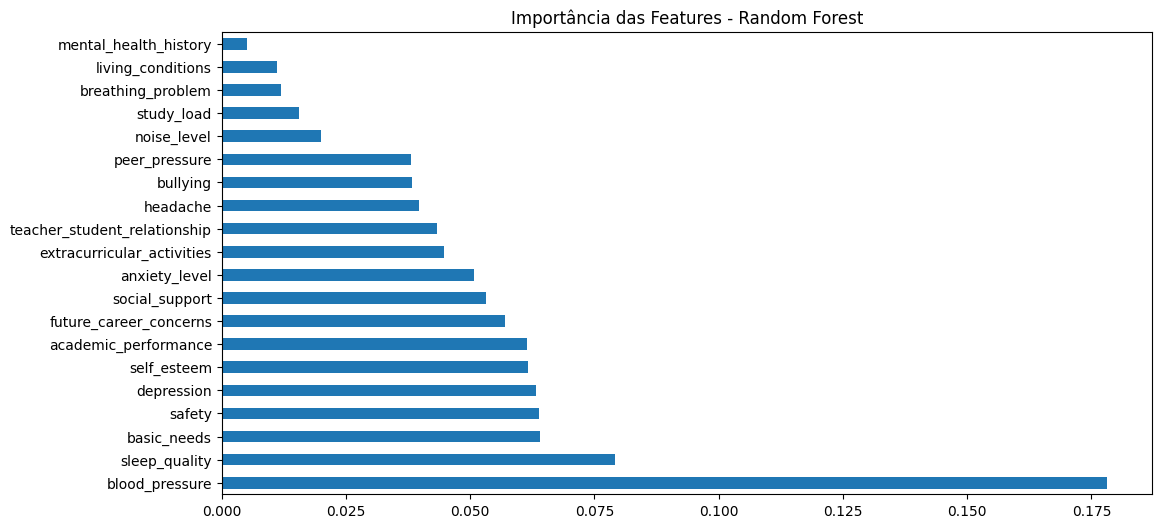

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Importâncias das variáveis (Random Forest):")
print(feat_importances)

feat_importances.plot(kind="barh", figsize=(12,6), title="Importância das Features - Random Forest")
plt.show()


Conclusão da Importância das Features (Random Forest)


- Consistência na Dominância Fisiológica:

*blood_pressure* (0.178): Mais uma vez, é a variável mais importante, com uma pontuação significativamente maior que a segunda colocada. Isso confirma que, independentemente da metodologia (MI, RFE ou RF), a pressão sanguínea é o marcador mais forte para prever o stress_level neste dataset.

- Aumento na Relevância de Fatores de Vida e Higiene:

O RF revela que fatores que pareciam secundários na Regressão Logística agora têm alta importância:

  - *sleep_quality* (0.079): Mantém-se forte, sendo a segunda mais importante.

  - *basic_needs* (0.064) e *safety* (0.064): Estes fatores de segurança e necessidades básicas (ambientais) saltaram para o Top 5, demonstrando que a estabilidade do ambiente de vida é crucial, e a Random Forest consegue modelar essa importância de forma mais eficaz que o modelo linear (RFE).

- Fatores Psicossociais se Dispersam

Variáveis psicológicas fortes (*depression, self_esteem, academic_performance, future_career_concerns, anxiety_level*) estão agrupadas entre o 5º e o 10º lugar.

- O Random Forest distribui a importância entre essas features psicológicas. Isso sugere que o efeito do estresse não se deve a apenas uma delas, mas sim ao seu efeito combinado.

  - depression (0.063)

  - self_esteem (0.062)

  - academic_performance (0.061)

- Baixa Importância Persistente

As variáveis consideradas fracas permanecem consistentemente no final do ranking em todas as metodologias:

  - *mental_health_history* (0.005): É o preditor mais fraco em todos os testes. Sua contribuição é quase nula.

  - Outras variáveis com importâncias muito baixas: *living_conditions, breathing_problem, study_load*.

### Heatmap para comparar

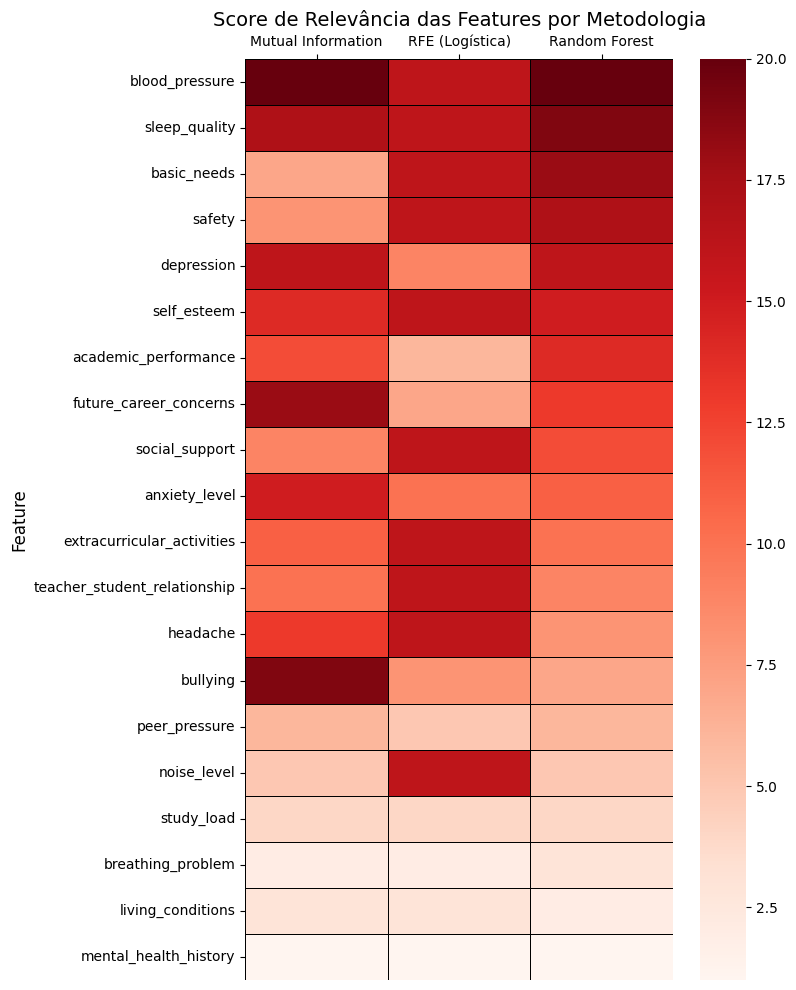

In [ ]:

mi_scores = pd.Series({
    'blood_pressure': 0.744964, 'bullying': 0.669996, 'future_career_concerns': 0.668781,
    'sleep_quality': 0.666586, 'depression': 0.660121, 'anxiety_level': 0.659608,
    'self_esteem': 0.624397, 'headache': 0.573681, 'academic_performance': 0.518681,
    'extracurricular_activities': 0.517744, 'teacher_student_relationship': 0.517739,
    'social_support': 0.513235, 'safety': 0.510815, 'basic_needs': 0.506121,
    'peer_pressure': 0.484187, 'noise_level': 0.446680, 'study_load': 0.391109,
    'living_conditions': 0.387597, 'breathing_problem': 0.367571, 'mental_health_history': 0.239563
})
rfe_ranking_raw = pd.Series({
    'self_esteem': 1, 'sleep_quality': 1, 'blood_pressure': 1, 'headache': 1,
    'teacher_student_relationship': 1, 'basic_needs': 1, 'safety': 1, 'noise_level': 1,
    'extracurricular_activities': 1, 'social_support': 1,
    'anxiety_level': 11, 'depression': 12, 'bullying': 13, 'future_career_concerns': 14,
    'academic_performance': 15, 'peer_pressure': 16, 'study_load': 17,
    'living_conditions': 18, 'breathing_problem': 19, 'mental_health_history': 20
})
rf_scores = pd.Series({
    'blood_pressure': 0.178220, 'sleep_quality': 0.079069, 'basic_needs': 0.063954,
    'safety': 0.063777, 'depression': 0.063207, 'self_esteem': 0.061584,
    'academic_performance': 0.061436, 'future_career_concerns': 0.057073,
    'social_support': 0.053195, 'anxiety_level': 0.050663,
    'extracurricular_activities': 0.044671, 'teacher_student_relationship': 0.043384,
    'headache': 0.039769, 'bullying': 0.038295, 'peer_pressure': 0.038077,
    'noise_level': 0.019888, 'study_load': 0.015498, 'breathing_problem': 0.011981,
    'living_conditions': 0.011208, 'mental_health_history': 0.005052
})

mi_score = 21 - mi_scores.rank(ascending=False).astype(int)
rf_score = 21 - rf_scores.rank(ascending=False).astype(int)

rfe_score = 21 - rfe_ranking_raw.rank(ascending=True).astype(int)

df_heatmap = pd.DataFrame({
    'Mutual Information': mi_score,
    'RFE (Logística)': rfe_score,
    'Random Forest': rf_score
}).sort_values(by='Random Forest', ascending=False)



plt.figure(figsize=(8, 10))
sns.heatmap(
    df_heatmap,
    annot=False,
    fmt="d",
    cmap="Reds",
    #cbar_kws={'label': 'Score de Relevância (20 = Mais Forte, 1 = Mais Fraco)'},
    linewidths=.5,
    linecolor='black'
)


plt.title('Score de Relevância das Features por Metodologia', fontsize=14)
plt.ylabel('Feature', fontsize=12)
plt.xlabel('')
plt.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### RANKING

In [ ]:
df_heatmap["Score Médio"] = df_heatmap.mean(axis=1)
df_heatmap.sort_values(by="Score Médio", ascending=False, inplace=True)
print(df_heatmap.head(10))


                            Mutual Information  RFE (Logística)  \
blood_pressure                              20               16   
sleep_quality                               17               16   
self_esteem                                 14               16   
basic_needs                                  7               16   
safety                                       8               16   
depression                                  16                9   
future_career_concerns                      18                7   
social_support                               9               16   
extracurricular_activities                  11               16   
headache                                    13               16   

                            Random Forest  Score Médio  
blood_pressure                         20    18.666667  
sleep_quality                          19    17.333333  
self_esteem                            15    15.000000  
basic_needs                       

### PCA

Redução de Dimensionalidade

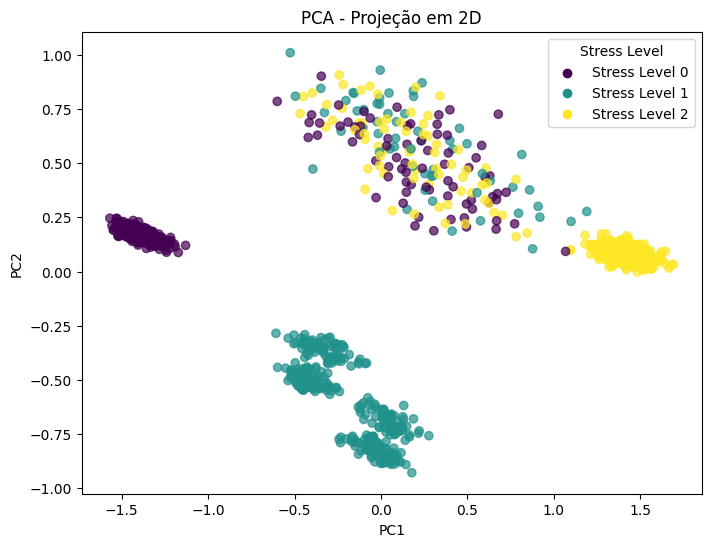

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))

scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="viridis", alpha=0.7)


classes = [0, 1, 2]
colors = [scatter.cmap(scatter.norm(c)) for c in classes]
for cls, color in zip(classes, colors):
    plt.scatter([], [], c=[color], label=f"Stress Level {cls}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")
plt.legend(title="Stress Level")
plt.show()


#### CONCLUSÃO


- Algumas classes aparecem agrupadas em regiões distintas, o que indica que parte da variância dos dados está associada ao nivel de estresse

- Mas, tem sobreposição significativa entre as classes
- Isso significa que a separação natural dos dados apenas pelas variancias não é tão clara, e modelos simples podem ter dificuldade em classificar

- Variancia explicada pelos 2 primeiros componentes é limitada: o dataset possui informações distribuidas em multiplas dimensoes

**PCA reduz a dimensionalidade e ajuda na visualização, mas não garante uma boa separação entre os niveis de estresse**

### LDA

Redução da Dimensionalidade Supervisionada

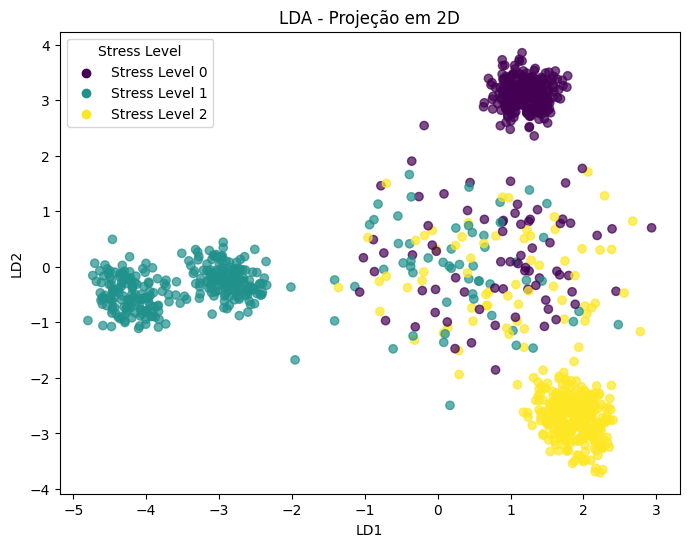

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y)

plt.figure(figsize=(8,6))


scatter = plt.scatter(X_lda[:,0], X_lda[:,1], c=y, cmap="viridis", alpha=0.7)


classes = [0, 1, 2]
colors = [scatter.cmap(scatter.norm(c)) for c in classes]
for cls, color in zip(classes, colors):
    plt.scatter([], [], c=[color], label=f"Stress Level {cls}")

plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA")
plt.legend(title="Stress Level")
plt.show()


#### CONCLUSÃO

- similar ao PCA: sobreposição significativa entre as classes

## DEFINIR E SALVAR OS SUBCONJUNTOS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
DRIVE_PATH = '/content/drive/MyDrive/MATERIAS/INF493_CD/TRAB_FINAL/dataset/Student_Stress_Monitoring_Datasets/'
os.makedirs(DRIVE_PATH, exist_ok=True)

# SALVAR AS PRIMEIRAS: 10 e 5 FEATURES MAIS IMPORTANTES
TOP_NS = [10, 5]

for TOP_N in TOP_NS:
    # Mutual Information
    top_mi = mi_scores.sort_values(ascending=False).head(TOP_N).index
    X_mi = X[top_mi]
    X_mi.to_csv(f"{DRIVE_PATH}X_mi_top{TOP_N}.csv", index=False)

    # RFE
    top_rfe = rfe_ranking_raw[rfe_ranking_raw == 1].index
    X_rfe = X[top_rfe]
    X_rfe.to_csv(f"{DRIVE_PATH}X_rfe_top{TOP_N}.csv", index=False)

    # Random Forest
    top_rf = rf_scores.sort_values(ascending=False).head(TOP_N).index
    X_rf = X[top_rf]
    X_rf.to_csv(f"{DRIVE_PATH}X_rf_top{TOP_N}.csv", index=False)

# Todas as features
X_all = X.copy()
X_all.to_csv(f"{DRIVE_PATH}X_all.csv", index=False)



Subconjuntos de atributos salvos com sucesso!
